In [1]:
!pip install requests
!pip install pandas
!pip install mp-api
!pip install requests-html

In [2]:
import csv
import os
import pandas as pd
from mp_api.client import MPRester
from ast import literal_eval
import math
import random
import matplotlib.pyplot as plt
import seaborn
import subprocess

/home/murimikelvin/ML-perovskites-project/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
ROOT_DIR = os.path.abspath("")
# DATA_DIR = os.path.join(ROOT_DIR, 'CrabNet/data/materials_data')
DATA_DIR = os.path.join(ROOT_DIR, 'CrabNet/data/materials_data')
TRAINING_CSV_FILE = os.path.join(ROOT_DIR, "Vacancyenergydata.csv")
API_KEY = "3XX6x9Nd3cKWf9Q4wpaio64CBHFp2uDq"
TRAINING_DATA = []
mpr = MPRester(API_KEY)

print(TRAINING_CSV_FILE)

/home/murimikelvin/ML-perovskites-project/Vacancyenergydata.csv


/home/murimikelvin/ML-perovskites-project/venv/lib/python3.10/site-packages/mp_api/client/mprester.py:146: UserWarning: mpcontribs-client not installed. Install the package to query MPContribs data, or construct pourbaix diagrams: 'pip install mpcontribs-client'
  warnings.warn(


## Step1:Collecting data.

#### Load Training data.

In [4]:
df = pd.read_csv(TRAINING_CSV_FILE)
print(df.columns)
df = df[['Chemical formula', 'Vacancy energy [eV/O atom]']]
new_names = {
    'Chemical formula': 'chem_formula',
    'Vacancy energy [eV/O atom]': 'e_ovac'
}
df.rename(columns=new_names, inplace=True)
df = df.to_dict("records")
df[:10]


Index(['Chemical formula', 'A', 'B', 'In literature', 'Valence A', 'Valence B',
       'Radius A [ang]', 'Radius B [ang]', 'Lowest distortion',
       'Formation energy [eV/atom]', 'Stability [eV/atom]',
       'Magnetic moment [mu_B]', 'Volume per atom [A^3/atom]', 'Band gap [eV]',
       'a [ang]', 'b [ang]', 'c [ang]', 'alpha [deg]', 'beta [deg]',
       'gamma [deg]', 'Vacancy energy [eV/O atom]'],
      dtype='object')


[{'chem_formula': 'Ac2O3', 'e_ovac': '3.150'},
 {'chem_formula': 'AcAgO3', 'e_ovac': '0.817'},
 {'chem_formula': 'AcAlO3', 'e_ovac': '6.695'},
 {'chem_formula': 'AcAsO3', 'e_ovac': '3.634'},
 {'chem_formula': 'AcAuO3', 'e_ovac': '0.807'},
 {'chem_formula': 'AcBO3', 'e_ovac': '4.163'},
 {'chem_formula': 'AcBaO3', 'e_ovac': '-1.771'},
 {'chem_formula': 'AcBeO3', 'e_ovac': '-0.080'},
 {'chem_formula': 'AcBiO3', 'e_ovac': '2.653'},
 {'chem_formula': 'AcCaO3', 'e_ovac': '-1.025'}]

## Step 2: Data cleaning

#### Cleaning training data

In [5]:
# Splitting the data into training and predicting and saving this data.
TRAINING_DATA = [m for m in df if m['e_ovac'] != '-']
PREDICTION_DATA = [m for m in df if m['e_ovac'] == '-']



print("Materials in the csv file without E_Ovac: ", len(PREDICTION_DATA))
print("Materials in the csv file with E_Ovac: ", len(TRAINING_DATA))
print("Total materials in the csv file: ", len(df))


Materials in the csv file without E_Ovac:  415
Materials in the csv file with E_Ovac:  4914
Total materials in the csv file:  5329


In [6]:
print(TRAINING_DATA[0])

{'chem_formula': 'Ac2O3', 'e_ovac': '3.150'}


In [7]:
print(PREDICTION_DATA[0])

{'chem_formula': 'AcMgO3', 'e_ovac': '-'}


In [8]:
print(min([x.get('e_ovac') for x in TRAINING_DATA]))
print(max([x.get('e_ovac') for x in TRAINING_DATA]))

-0.006
6.962


#### Create Model Training Data (Create train.csv, val.csv, test.csv)

In [9]:
## Split the data into train, test, val

random.shuffle(TRAINING_DATA) # Shuffle the training data list on every run
split_ratio = "6:2:2" # Set the ratio at with to split the data into train, test and validation sets from the training data list

ratios = [round(int(r)/10 * len(TRAINING_DATA)) for r in split_ratio.split(':')] # Get the number of materials from the training data list according tp the ratio

# Get X amount of data from the training dataset accoring to the set rratio
train_set = TRAINING_DATA[:ratios[0]] 
test_set = TRAINING_DATA[ratios[0]:(ratios[0] + ratios[1])]
val_set = TRAINING_DATA[(ratios[0] + ratios[1]):]

print(len(train_set), len(test_set), len(val_set))
print(ratios, sum(ratios), len(TRAINING_DATA))

print(train_set[:5])
print(test_set[:5])
print(val_set[:5])

2948 983 983
[2948, 983, 983] 4914 4914
[{'chem_formula': 'NdFeO3', 'e_ovac': '3.830'}, {'chem_formula': 'KPdO3', 'e_ovac': '-1.255'}, {'chem_formula': 'TmZnO3', 'e_ovac': '-0.492'}, {'chem_formula': 'SbCsO3', 'e_ovac': '-10.610'}, {'chem_formula': 'Co2O3', 'e_ovac': '-2.800'}]
[{'chem_formula': 'TeAgO3', 'e_ovac': '-3.908'}, {'chem_formula': 'LaHfO3', 'e_ovac': '5.446'}, {'chem_formula': 'Sr2O3', 'e_ovac': '-1.979'}, {'chem_formula': 'TbTiO3', 'e_ovac': '4.797'}, {'chem_formula': 'PaOsO3', 'e_ovac': '-1.791'}]
[{'chem_formula': 'LuBiO3', 'e_ovac': '0.107'}, {'chem_formula': 'MgYbO3', 'e_ovac': '-4.027'}, {'chem_formula': 'FeZrO3', 'e_ovac': '-0.155'}, {'chem_formula': 'TlEuO3', 'e_ovac': '-3.699'}, {'chem_formula': 'BiHfO3', 'e_ovac': '4.027'}]


In [10]:
## Save data to CSV

fields = ['formula', 'target']
train_rows = [[data.get('chem_formula'), data.get('e_ovac')] for data in train_set]
val_rows = [[data.get('chem_formula'), data.get('e_ovac')] for data in val_set]
test_rows = [[data.get('chem_formula'), data.get('e_ovac')] for data in test_set]

# print(rows)
## Create train.csv with train_set data
with open(os.path.join(DATA_DIR, 'train.csv'), 'w') as train_file:
    csvwriter = csv.writer(train_file)
    
    csvwriter.writerow(fields)
    csvwriter.writerows(train_rows)

## Create val.csv with train_set data
with open(os.path.join(DATA_DIR, 'val.csv'), 'w') as val_file:
    csvwriter = csv.writer(val_file)
    
    csvwriter.writerow(fields)
    csvwriter.writerows(val_rows)

## Create test.csv with train_set data
with open(os.path.join(DATA_DIR, 'test.csv'), 'w') as test_file:
    csvwriter = csv.writer(test_file)
    
    csvwriter.writerow(fields)
    csvwriter.writerows(test_rows)
    

#### Train the crabnet model

In [12]:
import sys; print(':'.join(x for x in sys.path if x))

/home/murimikelvin/ML-perovskites-project:/usr/lib/python310.zip:/usr/lib/python3.10:/usr/lib/python3.10/lib-dynload:/home/murimikelvin/ML-perovskites-project/venv/lib/python3.10/site-packages


In [21]:
# os.chdir("CrabNet")



/home/murimikelvin/ML-perovskites-project/CrabNet
b'Property "example_materials_property" selected for training\n'
b'\n'
b'Model architecture: out_dims, d_model, N, heads\n'
b'3, 512, 3, 4\n'
b'Running on compute device: cpu\n'
b'Model size: 11987206 parameters\n'
b'\n'


Generating EDM: 100%|██████████| 2948/2948 [00:00<00:00, 106316.38formulae/s]


b'loading data with up to 3 elements in the formula\n'
b'training with batchsize 256 (2**8.000)\n'


Generating EDM: 100%|██████████| 983/983 [00:00<00:00, 64534.82formulae/s]


b'loading data with up to 3 elements in the formula\n'
b'stepping every 12 training passes, cycling lr every 1 epochs\n'
b'checkin at 2 epochs to match lr scheduler\n'
b'Epoch: 0/40 --- train mae: 3.31 val mae: 3.13\n'
b'Epoch: 1/40 --- train mae: 3.3 val mae: 3.12\n'
b'Epoch: 3/40 --- train mae: 3.34 val mae: 3.17\n'
b'Epoch: 5/40 --- train mae: 3.11 val mae: 2.95\n'
b'Epoch: 7/40 --- train mae: 3.08 val mae: 2.93\n'
b'Epoch: 9/40 --- train mae: 3.05 val mae: 2.95\n'
b'Epoch: 11/40 --- train mae: 2.98 val mae: 2.88\n'
b'Epoch: 13/40 --- train mae: 2.95 val mae: 2.85\n'
b'Epoch: 15/40 --- train mae: 2.91 val mae: 2.82\n'
b'Epoch: 17/40 --- train mae: 2.9 val mae: 2.82\n'
b'Epoch: 19/40 --- train mae: 2.86 val mae: 2.81\n'
b'Epoch: 21/40 --- train mae: 2.84 val mae: 2.83\n'
b'Epoch: 23/40 --- train mae: 2.84 val mae: 2.83\n'
b'Epoch: 25/40 --- train mae: 2.81 val mae: 2.82\n'
b'Epoch 27 failed to improve.\n'
b'Discarded: 1/3 weight updates \xe2\x99\xbb\xf0\x9f\x97\x91\xef\xb8\x8f\n'
b'E

#### Analyzing training performance

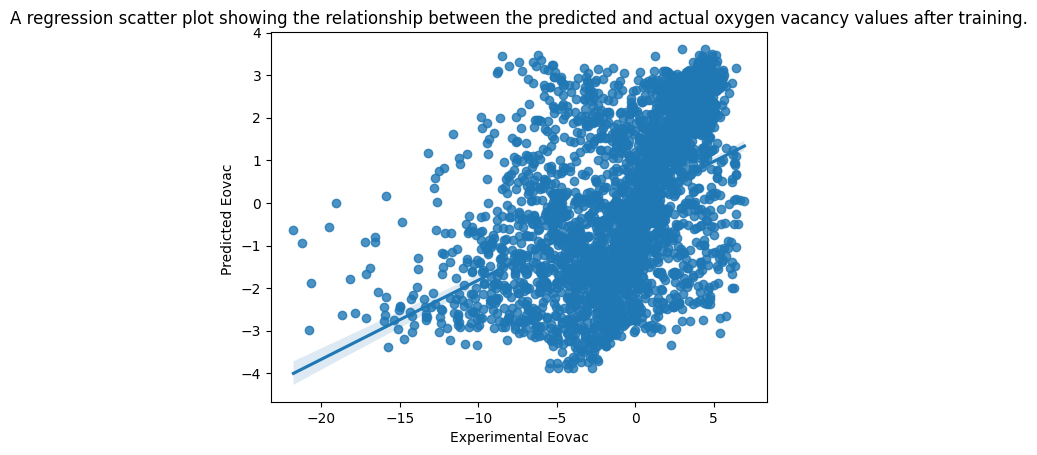

In [47]:

csv = pd.read_csv('CrabNet/model_predictions/example_materials_property_train_output.csv')
res = seaborn.regplot(x='target', y='pred-0', data=csv )
plt.title(f"A regression scatter plot showing the relationship between the predicted and actual oxygen vacancy values after training.")
plt.xlabel("Experimental Eovac")
plt.ylabel("Predicted Eovac ")

plt.show()

#### Create Prediction Data (Create train.csv, val.csv, test.csv)

In [22]:
## Split the data into train, test, val

random.shuffle(PREDICTION_DATA) # Shuffle the training data list on every run
split_ratio = "6:2:2" # Set the ratio at with to split the data into train, test and validation sets from the training data list

ratios = [round(int(r)/10 * len(PREDICTION_DATA)) for r in split_ratio.split(':')] # Get the number of materials from the training data list according tp the ratio

# Get X amount of data from the training dataset accoring to the set rratio
train_set = PREDICTION_DATA[:ratios[0]] 
test_set = PREDICTION_DATA[ratios[0]:(ratios[0] + ratios[1])]
val_set = PREDICTION_DATA[(ratios[0] + ratios[1]):]

print(len(train_set), len(test_set), len(val_set))
print(ratios, sum(ratios), len(PREDICTION_DATA))

print(train_set[:5])
print(test_set[:5])
print(val_set[:5])

249 83 83
[249, 83, 83] 415 415
[{'chem_formula': 'NiScO3', 'e_ovac': '-'}, {'chem_formula': 'NpCdO3', 'e_ovac': '-'}, {'chem_formula': 'PuPtO3', 'e_ovac': '-'}, {'chem_formula': 'NpDyO3', 'e_ovac': '-'}, {'chem_formula': 'PuNaO3', 'e_ovac': '-'}]
[{'chem_formula': 'TcCaO3', 'e_ovac': '-'}, {'chem_formula': 'NiEuO3', 'e_ovac': '-'}, {'chem_formula': 'NpYO3', 'e_ovac': '-'}, {'chem_formula': 'CoAuO3', 'e_ovac': '-'}, {'chem_formula': 'CsMnO3', 'e_ovac': '-'}]
[{'chem_formula': 'CoZnO3', 'e_ovac': '-'}, {'chem_formula': 'NiTmO3', 'e_ovac': '-'}, {'chem_formula': 'RhCsO3', 'e_ovac': '-'}, {'chem_formula': 'CrMgO3', 'e_ovac': '-'}, {'chem_formula': 'PuPaO3', 'e_ovac': '-'}]


In [23]:
## Save data to CSV

fields = ['formula', 'target']
train_rows = [[data.get('chem_formula'), random.randint(-1, 1)] for data in train_set]
val_rows = [[data.get('chem_formula'), random.randint(-1, 1)] for data in val_set]
test_rows = [[data.get('chem_formula'), random.randint(-1, 1)] for data in test_set]

# print(rows)
## Create train.csv with train_set data
with open(os.path.join(DATA_DIR, 'train.csv'), 'w') as train_file:
    csvwriter = csv.writer(train_file)
    
    csvwriter.writerow(fields)
    csvwriter.writerows(train_rows)

## Create val.csv with train_set data
with open(os.path.join(DATA_DIR, 'val.csv'), 'w') as val_file:
    csvwriter = csv.writer(val_file)
    
    csvwriter.writerow(fields)
    csvwriter.writerows(val_rows)

## Create test.csv with train_set data
with open(os.path.join(DATA_DIR, 'test.csv'), 'w') as test_file:
    csvwriter = csv.writer(test_file)
    
    csvwriter.writerow(fields)
    csvwriter.writerows(test_rows)
    

In [37]:
print(min([x.get('e_ovac') for x in TRAINING_DATA]))

-0.006


#### Analyze predicted values

In [16]:
## Read the predictions from the csv files

PRED_DIR = os.path.join(ROOT_DIR, "CrabNet/model_predictions/")
print(PRED_DIR)
csv_files = os.listdir(PRED_DIR)

predicted_data = []
for _file in csv_files:
    with open(os.path.join(PRED_DIR, _file)) as train_file:
        csv_reader = csv.reader(train_file)
        
        row_count = 0
        for row in csv_reader:
            if row_count != 0:
#                 print(row)
                predicted_data.append({
                    "structure": row[1],
                    "predicted_e_ovac": row[3]
                })
            
            row_count += 1

            
print(predicted_data[:5])
print(len(predicted_data))
 

/home/murimikelvin/ML-perovskites-project/CrabNet/model_predictions/
[{'structure': 'AuNiO3', 'predicted_e_ovac': '-2.4784889221191406'}, {'structure': 'AcHgO3', 'predicted_e_ovac': '-1.1984041929244995'}, {'structure': 'OsCrO3', 'predicted_e_ovac': '-0.2320016622543335'}, {'structure': 'AcEuO3', 'predicted_e_ovac': '-0.6989082098007202'}, {'structure': 'NaHoO3', 'predicted_e_ovac': '-1.5705665349960327'}]
4914


In [17]:
print(min([x.get('predicted_e_ovac') for x in predicted_data]))
print(max([x.get('predicted_e_ovac') for x in predicted_data]))

-0.0012600421905517578
3.6155831813812256
